# Introduction to signal processing (Master Erasmus Mundus CYBER)

## Imports and utility functions

In [ ]:
from dataclasses import dataclass

import numpy as np
import scipy
import statsmodels.api as sm
from matplotlib import pyplot as plt
from numpy.typing import NDArray
from statsmodels.tsa.stattools import acf

DATA = np.load("DataTP.npz", allow_pickle=True)["arr_0"].tolist()

In [ ]:
@dataclass
class Datum:
    left: NDArray  # angular velocity aroung axis (Oy) of the left foot
    right: NDArray  # angular velocity aroung axis (Oy) of the right foot
    age: int  # subject's age
    label: str  # pathology group

    @property
    def n_samples(self) -> int:
        return self.left.shape[0]

In [ ]:
def load_trial(trial_id: int) -> Datum:
    return Datum(**DATA[trial_id])

In [ ]:
def plot_acf(signal: NDArray, ax=None):
    sm.graphics.tsa.plot_acf(signal, ax=ax, lags=200, alpha=None)


def get_acf(signal) -> NDArray:
    return acf(signal, nlags=200)

In [ ]:
def generate_step_signal(n_samples):
    """Return a step signal of shape (n_samples,)."""
    step_signal = np.sign(np.linspace(-1, 1, n_samples))
    step_signal -= step_signal.mean()
    return step_signal


def get_harmonic_approximation(signal: NDArray, n_harmonics: int = 1) -> NDArray:
    """Return the approximation of the 1D signal with n_harmonics."""
    fourier_coeff = np.fft.rfft(signal)
    keep_indexes = np.argsort(abs(fourier_coeff))[-n_harmonics:]
    fourier_filtered = np.zeros_like(fourier_coeff)
    fourier_filtered[keep_indexes] = fourier_coeff[keep_indexes]
    step_signal_approx = np.fft.irfft(fourier_filtered)
    return step_signal_approx

In [ ]:
def fig_ax(figsize=(20, 5)):
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xmargin(0)
    return fig, ax

## Introduction

#### Context
The study of human gait is a central problem in medical research with far-reaching consequences in the public health domain. This complex mechanism can be altered by a wide range of pathologies (such as Parkinson’s disease, arthritis, stroke,...), often resulting in a significant loss of autonomy and an increased risk of fall. Understanding the influence of such medical disorders on a subject's gait would greatly facilitate early detection and prevention of those possibly harmful situations. To address these issues, clinical and bio-mechanical researchers have worked to objectively quantify gait characteristics.

Among the gait features that have proved their relevance in a medical context, several are linked to the notion of step (step duration, variation in step length, etc.), which can be seen as the core atom of the locomotion process. Many algorithms have therefore been developed to automatically (or semi-automatically) detect gait events (such as heel-strikes, heel-off, etc.) from accelerometer/gyrometer signals.

Most of the time, the algorithms used for step detection are dedicated to a specific population (healthy subjects, elderly subjects, Parkinson patients, etc.) and only a few publications deal with heterogeneous populations composed of several types of subjects. Another limit to existing algorithms is that they often focus on locomotion in established regime (once the subject has initiated its gait) and do not deal with steps during U-turn, gait initiation or gait termination. Yet, initiation and termination steps are particularly sensitive to pathological states. For example, the first step of Parkinsonian patients has been described as slower and smaller that the first step of age-matched subjects. U-turn steps are also interesting since 45% of daily living walking is made up of turning steps, and when compared to straight-line walking, turning has been emphasized as a high-risk fall situation. This argues for reliable algorithms that could detect initiation, termination and turning steps in both healthy and pathological subjects.


#### Data collection
The data was collected between April 2014 and October 2015 by monitoring healthy (control) subjects and patients from several medical departments (see publication for more information). Participants are divided into three groups depending on their impairment:

* Healthy subjects had no known medical impairment (labelled as "T" for Témoin).
* The orthopedic group is composed of 3 cohorts of distinct pathologies: lower limb osteoarthrosis (ArtH, ArtG), cruciate ligament injury (LCA), knee injury (Genou)
* The neurological group is composed of 2 cohorts: cerebellar disorder (CER) and radiation induced leukoencephalopathy (LER)


### Protocol

All subjects underwent the same protocol described below. First, a IMU (Inertial Measurement Unit) that recorded angular velocities was attached to the dorsal face of each foot. All signals have been acquired at 100 Hz with XSens sensors. After sensor fixation, participants were asked to perform the following sequence of activities:

* stand for 6 s,
* walk 10 m at preferred walking speed on a level surface to a previously shown turn point,
* turn around (without previous specification of a turning side),
* walk back to the starting point,
* stand for 2 s.

Subjects walked at their comfortable speed with their shoes and without walking aid. 
This protocol is schematically illustrated in the following figure.

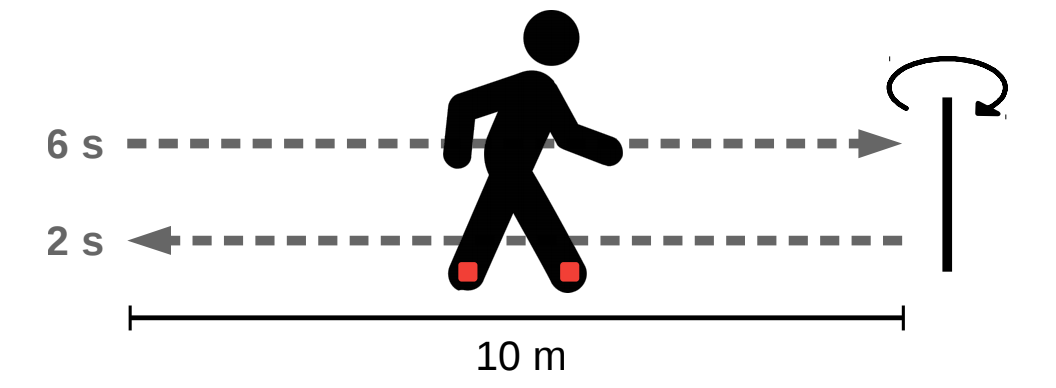

#### Signals

Each IMU records its acceleration and angular velocity in the  $(X,Y,Z,V)$  set of axes defined in the following figure. The  $V$  axis is aligned with gravity, while the  $X$ ,  $Y$  and  $Z$  axes are attached to the sensor. **In this session, signals only consist of the angular velocity aroung axis $Y$**

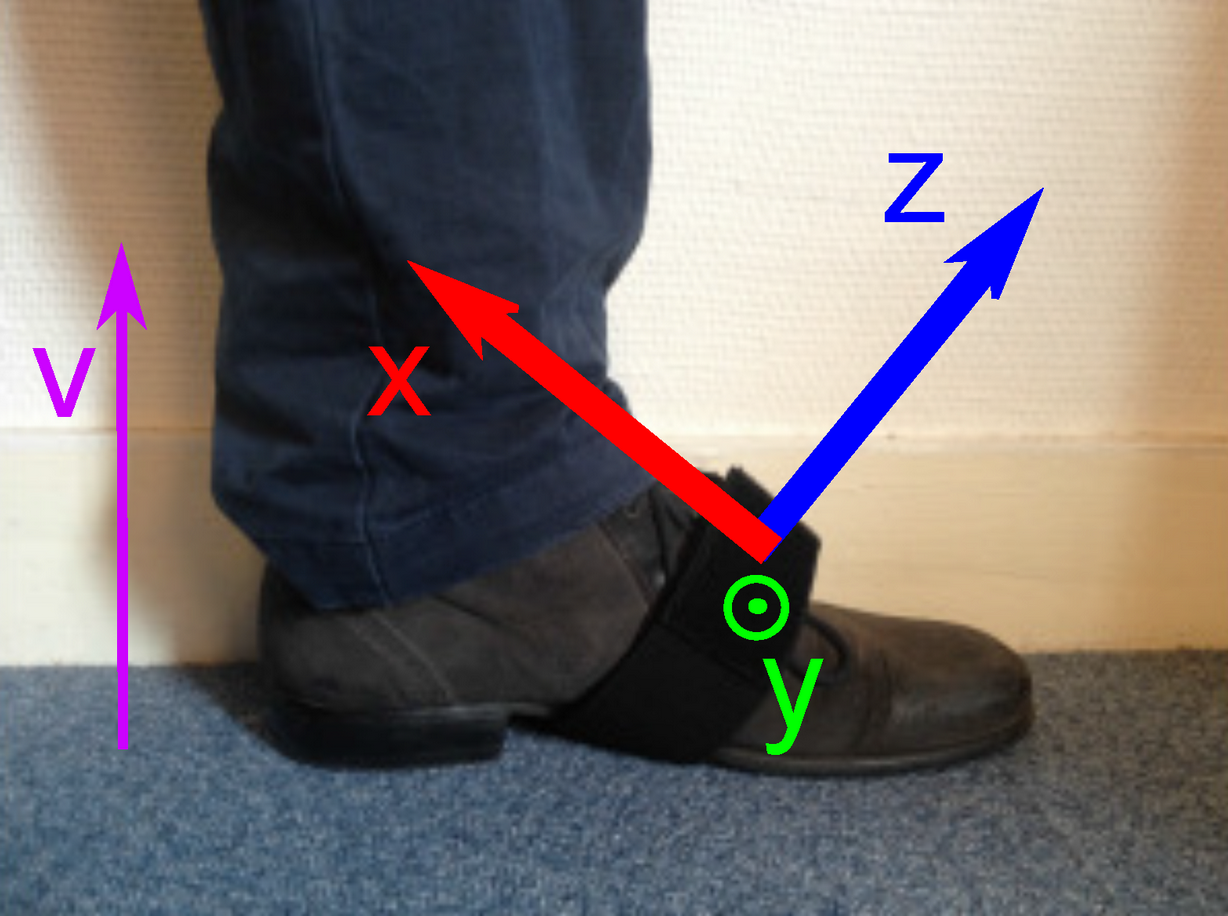


In total we included 221 recordings for this tutorial session.

Indexes:
- ArtH  [27, 28]
- LCA   [73, 74]
- CER   [116, 117, 118, 119, 120, 186, 187]
- ArtG  [121, 122]
- LER   [137, 138, 139, 140, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220]
- Genou [150, 151]

## Data exploration

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the sampling frequency?</p>
</div>

In [ ]:
SAMPLING_FREQUENCY = ...  # Hz

In [ ]:
# Let us load a trial

trial = load_trial(0)

In [ ]:
fig, ax = fig_ax()

# Create a time vector
time_array = np.arange(trial.n_samples) / SAMPLING_FREQUENCY

# Plot angular velocities
ax.plot(time_array, trial.left, label="Left foot")
ax.plot(time_array, trial.right, label="Right foot")

# add labels to axis and title
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angular velocity (deg/s)")
ax.set_title(f"Pathology: {trial.label}, age: {trial.age}")
_ = plt.legend()

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What can you tell about this signal? Compare with a subject with knee arthritis (label "ArtG").</p>    
</div>

## Estimate the step frequency with autocorrelation

In [ ]:
# Choose a trial
trial = load_trial(14)

# plot the autocorrelation function (acf)
plot_acf(trial.right)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Visually, what is the step period (in Hz)?</p>
    <p>Compute it (use the autocorrelation array and the `np.argmax` function).</p>
    <p>Do the same thing with a subject with knee arthritis. Compare the two periods.</p>
    
</div>

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Compute it (use the autocorrelation array and the `np.argmax` function).</p>    
</div>

In [ ]:
# Compute the autocorrelation values
autocorr = get_acf(trial.right)

...  # your code

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Do the same thing with a subject with knee arthritis. Compare the two periods.</p>    
</div>

In [ ]:
# Choose a trial
trial = load_trial(...)

# Compute the autocorrelation values
autocorr = get_acf(trial.right)


...  # your code

## Time-frequency analysis

Locomotion of healthy subjects is almost assimilable to a periodic phenomenon: it therefore makes sense to study it in the time-frequency domain.

### Frequency domain

The signal $\{x_1,x_2,\dots,x_T\}$ can be written as Fourier series:

$$x_t = \frac{a_0}{2} +  \displaystyle\sum_{n=1}^{\infty} a_n \cos\left(2\pi \frac{n t}{T}\right) +  b_n \sin\left(2\pi \frac{n t}{T}\right).$$

The coefficients $(a_n, b_n)$ are the coefficients of the Discrete Fourier Transform (DFT).

To study the frequency content, we display the values of $a_n^2 + b_n^2$.

In [ ]:
n_samples = 100
n_harmonics = 1

# generate a step signal
step_signal = generate_step_signal(n_samples=n_samples)

# compute the best harmonic approximation
step_signal_approx = get_harmonic_approximation(
    signal=step_signal, n_harmonics=n_harmonics
)

# display the signal and its approximation
fig, ax = fig_ax(figsize=(8, 4))
ax.plot(step_signal)
ax.plot(step_signal_approx)

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What happens when the number of harmonics increases?</p>    
</div>

In [ ]:
# We can compute the complete Fourier transform

fourier_coeff = abs(np.fft.rfft(trial.left))
freqs = np.fft.rfftfreq(trial.n_samples, d=1 / SAMPLING_FREQUENCY)
fig, ax = fig_ax(figsize=(8, 3))
ax.plot(freqs, fourier_coeff)
ax.set_xlabel("Frequency (Hz)")
_ = ax.set_ylabel("Power")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>What is the main frequency? (Use the `np.argmax` function.)</p>    
</div>

In [ ]:
...  # your code

### Short-time Fourier Transform

The STFT (Short-Term Fourier Transform) consists in computing Fourier transform on overlapping frames and display it in a matrix form.

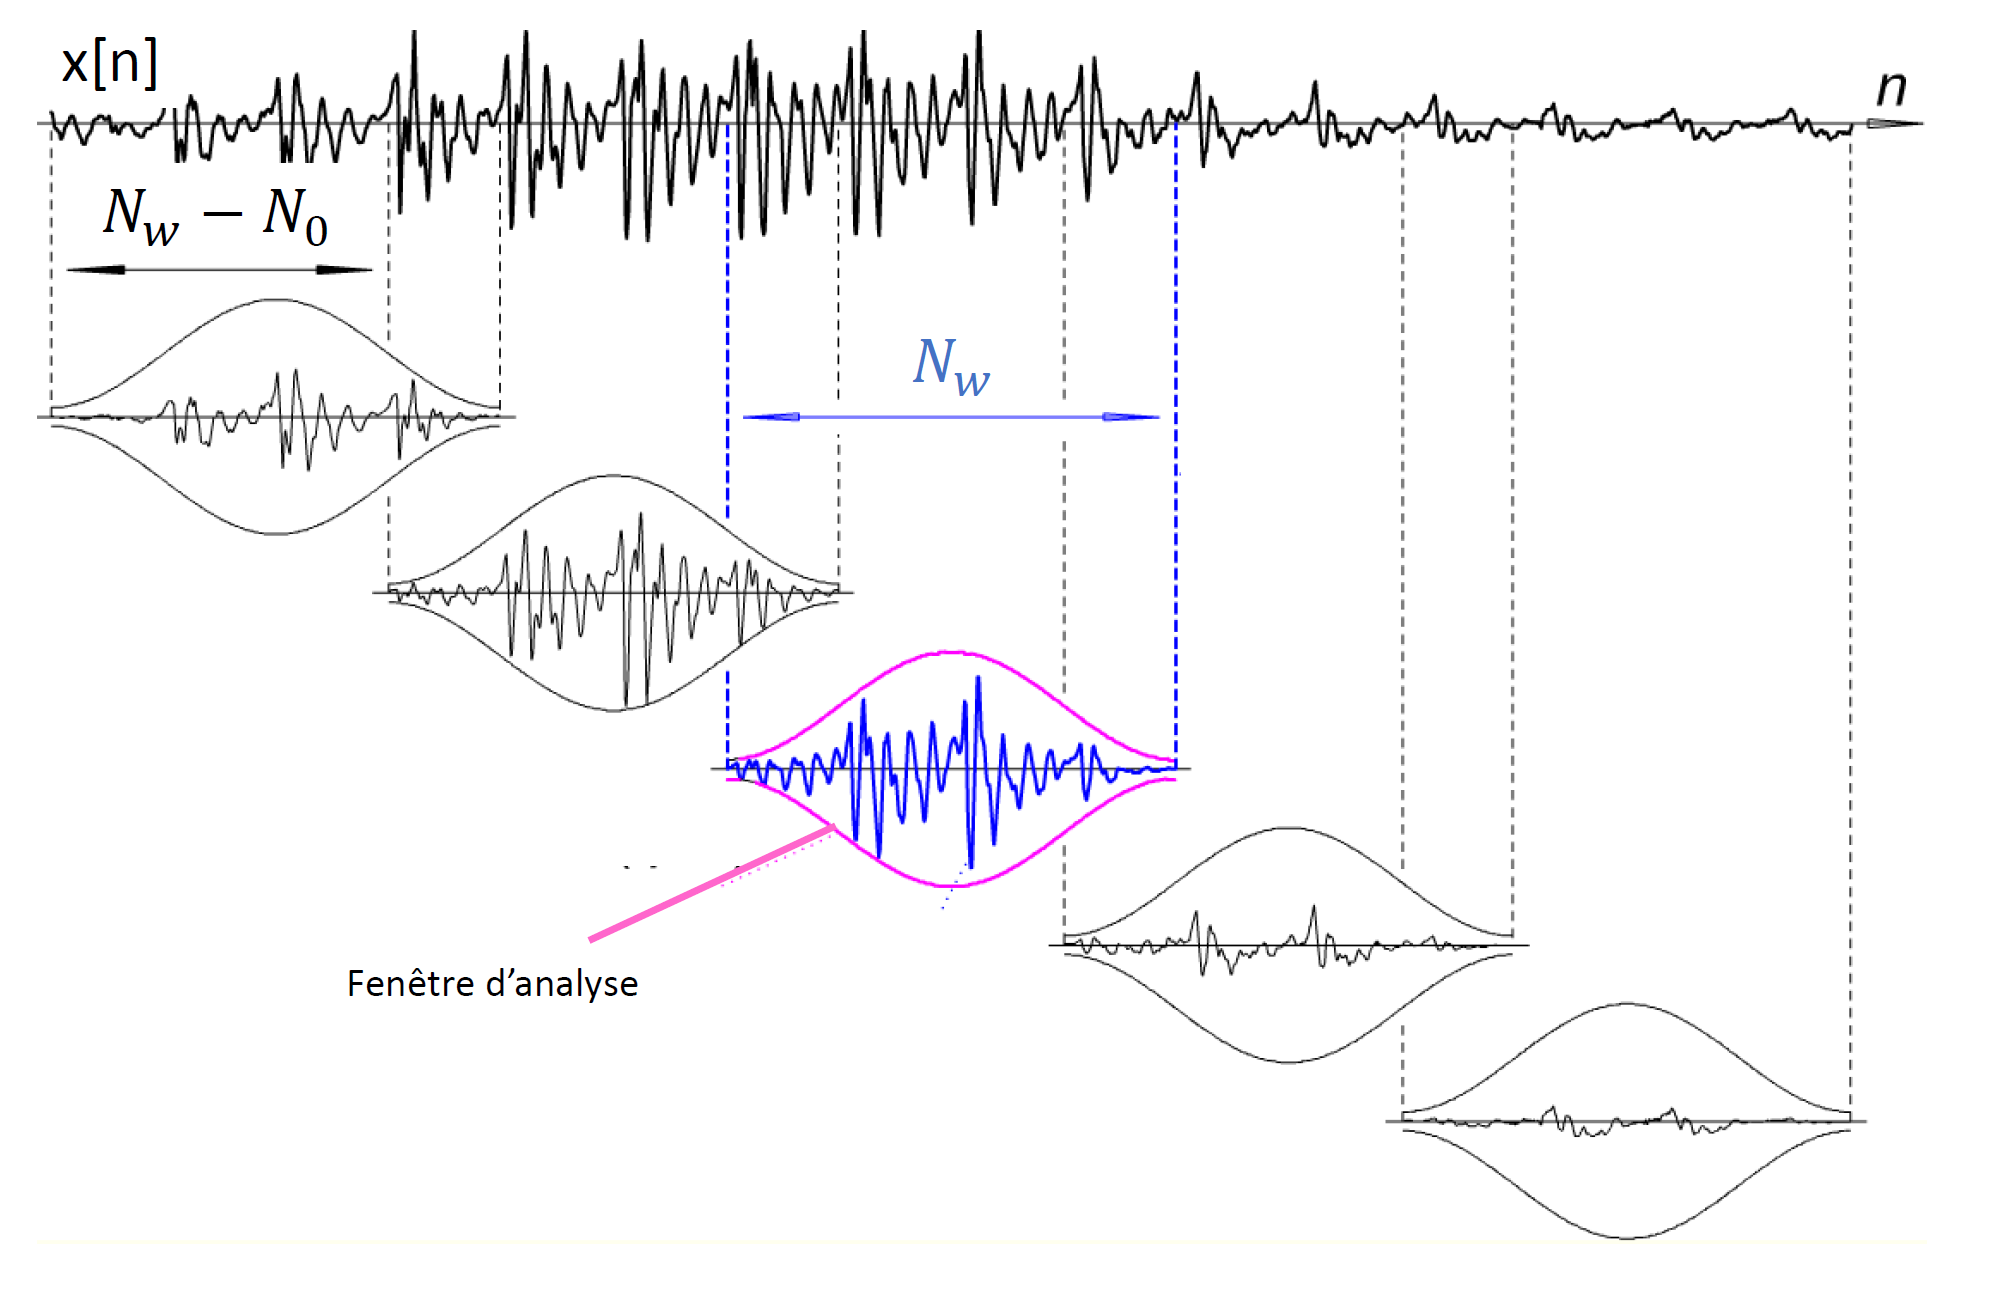

We display the absolute square of the STFT, often referred to as a **spectrogram**. This representation requires the specification of several parameters:
* $N_w$: window length (in samples). Often taken as a power of 2 (for FFT) and linked to the desired frequency resolution. 
* $N_o$: overlap between two successive frames (in samples). Often taken as  50\% or 75\% of the window length and characterizes the time resolution (optimal when $N_o=N_w-1$) 
* $w$: analysis window (Hann, Hamming, Blackman...). Traditionally, in order to limit side effects, the signal frame is multiplied by an analysis window 


In [ ]:
def plot_spectrogram(signal: NDArray, nperseg: int, noverlap: int):
    """Compute and display the spectrogram.

    nperseg is the window length and noverlap is the overlap length.
    """
    # Compute spectrogram
    freqs, time_array, Sxx = scipy.signal.stft(
        x=signal, fs=SAMPLING_FREQUENCY, nperseg=nperseg, noverlap=noverlap
    )
    # Display spectrogram
    fig, ax = fig_ax(figsize=(10, 5))
    ax.pcolormesh(time_array, freqs, abs(Sxx))
    ax.set_xlabel("Time (second)")
    ax.set_ylabel("Frequency (Hz)")

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>Display the spectrogram for a window of 3 seconds and an overlap of 2.99 seconds. What do you observe?</p>    
</div>

In [ ]:
plot_spectrogram(trial.left, ..., ...)

### Filtering a signal

In order to extract a phenomenon of interest from a signal (or to remove a spurious one), it is possible to apply a filter that will amplify/diminish some frequencies in the signal spectrum and transform the original signal $\{x_t\}_t$ into a filtered signal $\{y_t\}_t$. 

Four main types are mainly used : 
* low-pass filters (remove high frequencies)
* high-pass filters (remove low frequencies)
* band-pass filters (remove all frequencies that do not belong to a specified frequency band)
* band-stop filters (remove all frequencies that  belong to a specified frequency band).

The filters are characterized by their cut-off frequencies (one for low- and high-pass filters and two for band-pass and band-stop filters).

In [ ]:
def apply_low_pass_filter(signal: NDArray, cutoff_freq: float):
    b, a = scipy.signal.butter(
        N=4, Wn=cutoff_freq, btype="lowpass", output="ba", fs=SAMPLING_FREQUENCY
    )
    filtered = scipy.signal.filtfilt(b=b, a=a, x=signal)
    return filtered

<div class="alert alert-success" role="alert">
    <p><b>Question</b></p>
    <p>In the following cell, choose a cutoff frequency.</p>    
    <p>What happens when it varies?</p>    
    <p>What is an appropriate cut-off frequency?</p>    
</div>

In [ ]:
cutoff_freq = ...  # Hz

# filter signal
filtered = apply_low_pass_filter(trial.left, cutoff_freq=cutoff_freq)

fig, ax = fig_ax()
# Create a time vector
time_array = np.arange(trial.n_samples) / SAMPLING_FREQUENCY

# Plot angular velocities
ax.plot(time_array, trial.left, label="Left foot")
ax.plot(time_array, filtered, label="Filtered")

# add labels to axis and title
ax.set_xlabel("Time (s)")
ax.set_ylabel("Angular velocity (deg/s)")
_ = plt.legend()